In [1]:
#|default_export conv

### Convolutions

In [6]:
#|export
import torch
import torch.nn as nn
from torch.utils.data import default_collate
from miniai.training import *
from miniai.datasets import *

In [21]:
import gzip,pickle,matplotlib.pyplot as plt,numpy as np
import matplotlib as mpl
import pandas as pd
mpl.rcParams['image.cmap'] = 'gray'

In [8]:
with gzip.open('../data/mnist.pkl.gz', 'rb') as f: data = pickle.load(f, encoding='latin')
((x_train,y_train),(x_val,y_val),_) = data
(x_train,y_train,x_val,y_val) = map(torch.tensor,(x_train,y_train,x_val,y_val))
(x_train.shape,y_train.shape,x_val.shape,y_val.shape)

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

### Understanding Convolution Equations

* https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c (How it differ from norm FNN)
* https://arxiv.org/pdf/1603.07285.pdf (Convolution Arithmetic)


* The mechanics is quite simple, you take your input image and flat it out all the pixel as a single vector and start multiply each pixel with it's corresponding weights and bias then you will get one output, and if you want multiple output, you can copy this same process, just with different weights for the each output, and finaly pass all the outputs through some non-linear function. this is our simple FNN operation. the only difference is, we are going to keep the same weights across multiple outputs and the number of weights are not going to be same as number of input pixels, actually number of weights will be much less than number of input pixels. because of this, each neurons will only be multiplied with few input pixels. But we don't want to miss any input pixels, to solve this issue what we can do is, each output focus on different set of pixels, means for each output, wieghts (same weights) will be multiplied with different set of input pixels, so this way, we cover all the input pixels.
 <br/>
    
* Now we need to choose which set of weights each outputs should focus on. this is done, simply by taking weights and reshaping it into 2D format, example if number of weights are 9 then it will be reshaped as 3x3. then you place it across image horizontal and vertical directions, each placement is the set of weights for each output.  that's it. this is "Convolution".


##### Convolution Arithmetic

* In Convolution operation output number of neurons depends on input size, number of weights, padding, and stride.
 <br/>
 
* Input size: number of input pixels.
 <br/>
 
* Padding: extra number of dummy pixels added to the inputs.
<br/>

* Stride: number of pixels needs to be skipped during sliding.
<br/>

* Number of weights (kernel size): size of the shared weights.


##### Deriving General Formula for the Output Size

```python
    # Asumme input is 1D, as it can be extended to 2D.
    # Input Size: W
    # Kernel Size: K
    # Number of Strides: S
    # Number of Paddings: P
    # Output Size: O
    
    # Case 1:
        # S=1, 0<K<W, P=0
        # In this case kernel sliding one pixel at a time on the input pixels
        # until it reaches the end where kernel no longer can be contained inside the pixels, so we exclude 
        # thoes end pixels.
        
        O = (W-K+1)
        
    # Case 2:
        # P>0, S=1, 0<K<W
        # If padding is greater than 0, which means those number extra dumpy pixels both the size,
        # so we need to multiply with 2.
        
        O = (W-k+1+2*P)
        
    # Case #:
        # P>0, S>1, 0<K<W
        # When stride is greater than 0, we are going to skip those many pixels.
        
        O = math.floor(((W-K+2*P)/S) + 1)

```

In [11]:
x_imgs = x_train.view(-1, 28, 28)
xv_imgs = x_val.view(-1, 28, 28)

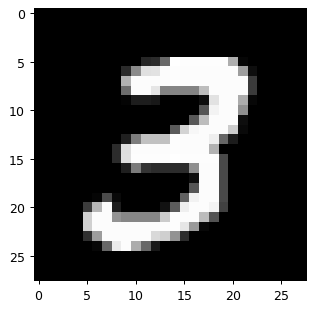

In [23]:
im3 = x_imgs[7]
mpl.rcParams['figure.dpi'] = 90
plt.imshow(im3)

##### What is Edge Detection?

Why processing image by multiplying small set of weights make sense?

https://en.wikipedia.org/wiki/Edge_detection

https://en.wikipedia.org/wiki/Sobel_operator

* Image is bunch of pixels with variying pixel intensity at different places.
* Key insight is varying pixel actualy changes how the image actualy looks to the observer, so if we are able to measure this pixel intensity changes, that may give some more clue to the actual image.
* Identifying this pixel intensity change across the image is called "edge detection".
* It turns out, we can do this by constructing the small weight matrix and multiply across the image and get the sum, which actually mathematical approximation for calculating pixel intensity changes.
* Depending on the weights value in the weight matrix, it calculate gradient across different direction.
* Initialy these weight matrix is hand coded for specific tasks.
* Now, instead of hand coding this weight matrirx we can ask our neural network to construct this matrix based on the objective function. hope was our network will learn useful weights.
* And it worked, network is able to fill up these weights.
* Eventhough it's one of the reason, another main reason is, just feeding raw pixels to normal FNN requires huge number of weights, so impossible to construct deep network or process large images.

In [45]:
df = pd.DataFrame(im3[:13, :23])
df.style.format(precision=2).set_properties(**{'font-size': '9pt'}).background_gradient('gray')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


##### Top Edge Kerenl 

This is hand coded kernel (weight matrix), this will help to identify top edges.

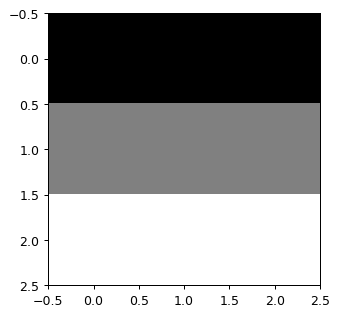

In [50]:
top_edges = torch.tensor([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1.],
])
plt.imshow(top_edges)

In [49]:
(im3[6:9, 10:13]*top_edges).sum()

tensor(0.5664)

In [62]:
def apply_kerenl(row, col, kerenl):
    return (im3[row-1:row+2, col-1:col+2]*kerenl).sum()

In [63]:
apply_kerenl(7, 11, top_edges)

tensor(0.5664)

In [64]:
rng = range(1,27)
im3_top_edges = [[apply_kerenl(i, j, top_edges) for j in rng] for i in rng]

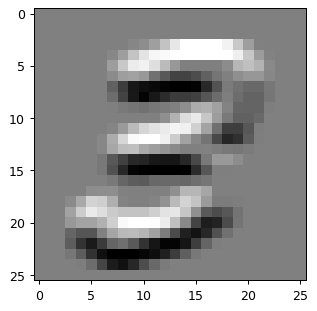

In [65]:
plt.imshow(im3_top_edges)

### Convolution in PyTorch

In [66]:
import torch.nn.functional as F
import torch

In [70]:
im3.shape

torch.Size([28, 28])

In [75]:
inp = im3[None,None,].float()
inp.shape

torch.Size([1, 1, 28, 28])

In [79]:
inp_unf = F.unfold(inp, 3)[0]
inp_unf.shape

torch.Size([9, 676])

In [80]:
w = top_edges.view(-1)
w.shape

torch.Size([9])

In [86]:
out = (w@inp_unf).view(26, 26)

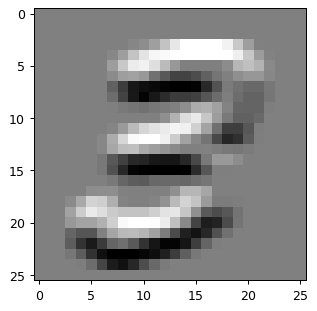

In [87]:
plt.imshow(out)

##### Time comparison

In [96]:
%timeit -n 1 [[apply_kerenl(i,j,top_edges) for j in rng] for i in rng]

14.2 ms ± 5.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [95]:
%timeit -n 100000 (w@inp_unf)

5.06 µs ± 123 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [104]:
%timeit -n 10000 F.conv2d(inp, top_edges[None,None,]).shape

25.1 µs ± 1.78 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [107]:
t1 = F.conv2d(inp, top_edges[None,None,])[0][0]
t2 = (w@inp_unf).view(26, 26)

In [108]:
t1.shape,t2.shape

(torch.Size([26, 26]), torch.Size([26, 26]))

In [109]:
torch.allclose(t1, t2)

True

### Let's Create CNN

* nn.Conv2d : helper function which do everythin we did so far, one difference is, it will assign kernels with random weights initialy, during training these weights will be updated.
* It will take number of input channels, in our case gray scale 1 start with, number of output channel, and usual params kernel size, stride, padding.
* Usually Channels in image means colors. 1 for gray, 3 for RGB combo colors, 4 for RGB colors with opacity option. but in our neural network channels means different after the first layer, once image processed by the first layer we can have more than 4 channels. in this context channel means, different kernel with different weights applied to the image, 4-channel means, 4 different kernels applied to the input image.
* Note: the reason we set padding = kernel_size//2 is, it allows to keep the original image size same. you can dervie this by working out the conv arithmetic mentioned above.

In [117]:
t = nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=3//2)
t

Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [120]:
t2 = t(inp)
t2.shape

torch.Size([1, 4, 14, 14])

In [138]:
#|export
def conv(ni, nf, ks=3, stride=2, act=True):
    res= nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2)
    if act:
        res = nn.Sequential(res, nn.ReLU())
    return res

In [136]:
simple_cnn = nn.Sequential(
    conv(1, 4), # 14x14
    conv(4, 8), # 7x7
    conv(8, 16), # 4x4
    conv(16, 16), # 2x2
    conv(16, 10, act=False),
    nn.Flatten(),
)

In [137]:
simple_cnn

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)